# Transformers

Transformer and train it on text data.

</br></br>

### Import Data and Libraries
---

In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
!wget https://raw.githubusercontent.com/dscape/spell/refs/heads/master/test/resources/big.txt

--2024-09-21 04:25:29--  https://raw.githubusercontent.com/dscape/spell/refs/heads/master/test/resources/big.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6488666 (6.2M) [text/plain]
Saving to: ‘big.txt.1’

big.txt.1           100%[===================>]   6.19M  --.-KB/s    in 0.09s   

2024-09-21 04:25:29 (68.2 MB/s) - ‘big.txt.1’ saved [6488666/6488666]



In [95]:
with open("big.txt") as f:
  text = f.read()

In [96]:
text[:100]

'The Project Gutenberg EBook of The Adventures of Sherlock Holmes\nby Sir Arthur Conan Doyle\n(#15 in o'

</br></br>

### Create Tokenizer and Preprocessor
---

In [97]:
chars = set(text)

stoi = {val:idx for (idx, val) in enumerate(chars)}
itos = {val:key for (key, val) in stoi.items()}

encode = lambda x: [stoi[i] for i in x]
decode = lambda x: [itos[i] for i in x]

In [98]:
torch.manual_seed(1337)
TRAIN_SIZE = 0.8
CONTEXT_LENGTH = 8
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
EMBEDDING_DIM = 32
VOCAB_SIZE = len(chars)
TRANSFORMER_BLOCKS = 2
ATTENTION_HEADS = 4
MAX_ITERS = 2000
LEARNING_RATE = 3e-4

In [99]:
encode("hello"), decode([35, 14, 15, 15, 44])

([26, 76, 69, 69, 63], ['t', '7', 'F', 'F', '>'])

In [100]:
tokenized_text = torch.tensor(encode(text))
tokenized_text.shape

torch.Size([6488666])

In [101]:
train_data = tokenized_text[:int(len(tokenized_text) * TRAIN_SIZE)]
test_data  = tokenized_text[int(int(len(tokenized_text) * TRAIN_SIZE)):]

train_data.to(DEVICE)
test_data.to(DEVICE)

tensor([61, 35, 74,  ..., 90, 77, 73])

In [102]:
torch.stack((torch.tensor([1, 2, 3]), torch.tensor([1, 2, 3])))

tensor([[1, 2, 3],
        [1, 2, 3]])

In [103]:
# Kind of a stochastic mini batch approach

def get_batch(data):
  # 32 Random indices in data
  indices = torch.randint(high=data.shape[0] - CONTEXT_LENGTH - 1, size=(BATCH_SIZE,))

  # X_batch is just 32 x 8, Y_batch is X_batch offset by one
  X_batch = torch.stack([data[i:i + CONTEXT_LENGTH].clone().detach()       for i in indices])
  Y_batch = torch.stack([data[i+1:i + CONTEXT_LENGTH + 1].clone().detach() for i in indices])

  return (X_batch.to(DEVICE), Y_batch.to(DEVICE))

In [104]:
get_batch(train_data)

(tensor([[74, 90, 76, 19, 63, 40, 86, 74],
         [63, 74, 26, 83, 90, 74, 76, 90],
         [26, 76, 74, 38, 43, 76, 90, 90],
         [63, 49, 69, 69, 74, 90, 53, 21],
         [63, 74, 26, 83, 90, 74, 76, 69],
         [74, 61, 40, 86, 74, 43, 76, 38],
         [83, 86, 76,  0, 24, 73, 73, 24],
         [63, 40, 74, 65, 26, 83, 19, 26],
         [83, 61,  0, 74, 57,  1, 76, 76],
         [11, 38, 61, 40, 51, 18, 74,  7],
         [74, 35, 26, 76, 74, 11, 63, 43],
         [ 6, 61, 40, 86, 76, 43, 74, 65],
         [74, 48, 53, 35, 74, 63, 40, 76],
         [83, 22, 76, 74, 35, 26, 76, 74],
         [83, 19, 63, 11, 35, 76, 36, 74],
         [19, 76, 43, 36, 74, 69, 63, 63],
         [74, 37, 26, 76, 74, 90, 61, 11],
         [83, 50, 83, 40,  0, 73, 73, 73],
         [53, 90, 76, 86, 74, 53, 38, 74],
         [69, 83, 61,  5, 69, 76, 73, 90],
         [76, 83, 22, 76, 86, 74,  5, 51],
         [40, 50, 74, 11, 63, 43, 76, 74],
         [76, 43, 36, 74,  5, 53, 35, 74],
         [7

</br></br>

### Create Model Architecture
---

`Transformer`
- **Embedding Layer**: converts token sequences to embeddings of length 32, embedding layer uses vocab size of the length of unique characters

</br>

- **Postitional Embedding Layer**: So batches are comprised of 8 tokens based on context length, to avoid, "the cat on the thing the", all the "the"s, we want each "the" to be slightly different since on different position, so each token embedding is added by a new trainable embedding layer corresponding to position. So its 8 "vocab" size and 32 dim length to add each 8, and just pass in [0, 1, 2, 3, 4, 5, 6, 7] as indexes to it to give the embedding.

</br>

- **Transformer Blocks**: Actual transformer blocks are sequential, so output of one block goes into next, and so on. Stacking enables a more powerful model to capture more complex dependencies.

</br>

- **Linear and Softmax**: Output of all sequence of transformer blocks is just the same B x T x C input, so now for each token in the batch, we want a probability distribution of the next token after the current one. So convert this B x T x C into a B x T x Vocab Size probability distribution

`Block`
- **Self-Attention Layer**: Passes in a B x T x Emb_dim input and the output of self attention is a reweighted output of the same input shape but contains information about which tokens influence the presence of other tokens.

</br>

- **Norm Layer**: The skip connection present is to offer a similar advantage like resnets, where there is a shorter path to from the start to the end of the model to allow a shorter gradient flow and eliminate the issue of multiple layers of randomness affecting the quality of the output and training speed. LayerNorm is used after the skip layer to normalize those outputs, and does so across the embedding dimension. Better than batchnorm since batchnorm requires fixed length inputs, but transformers should work on variable length.

</br>

- **FFNN**: Feed Forward Neural Net part is to add a layer of nonlinearity in the model, since attention is just a linear operation (dot products). Captures more intricate patterns. Also kind of like feature enhancement after recieveing the output of attention.



`Self Attention`
- **Multi headed attention**: Self attention uses multiple heads of attention where each head picks up on different features and patterns. Ultimately, all the outputs of attention are concatenated together as the output.

</br>

- **Norm Layer**: The skip connection present is to offer a similar advantage like resnets, where there is a shorter path to from the start to the end of the model to allow a shorter gradient flow and eliminate the issue of multiple layers of randomness affecting the quality of the output and training speed. LayerNorm is used after the skip layer to normalize those outputs, and does so across the embedding dimension. Better than batchnorm since batchnorm requires fixed length inputs, but transformers should work on variable length.

</br>

- **FFNN**: Feed Forward Neural Net part is to add a layer of nonlinearity in the model, since attention is just a linear operation (dot products). Captures more intricate patterns. Also kind of like feature enhancement after recieveing the output of attention.



`Attention`

Example being used is a bunch of recruiters who are not only looking for people for their job, but they themselves hate their jobs and want to switch, so they are looking for a job and finding people a job simultaneously.

</br>

- **Queries**: What is being looked for. Like a recruiter trying to find an employee for a job, giving a bunch of descriptions hoping to find the best match. Training this query matrix is like the recruiter iteratively developing the job description to attract the best possible candidates.

</br>

- **Keys**: Information currently possesed. Like skills and experience and information relavent to the recruiter for finding a job. Training the keys matrix is like continuously updating a resume or refining skills to make themselves more employable.

</br>

- **Values**: Opinions the recruiter has. When a query highly aligns with a key, meaning that a recruiter strongly fits another recruiter's need, the recruiter in search of the job is highly likely to listen and pay attention to the opinions and advice of the recruiter who is hiring for the job. Training values matrix is like generating opinions and advice and saying things that would benefit the job seeking recruiter more.

</br>

1. Queries, keys, and values matrix is derived from taking dot product of initial Q, K, and V matrices with the B x T x C input. So would result in B x T x new_head_emb size. So for instance, this new queries matrix would represent what each token is looking for, and contains 'new_head_emb' length of values encoding the information of what the token is looking for. Same for keys and values.
2. $QK^T$ ends up being a matrix comparing each job-seeking recruiter to each employee-seeking recruiter, and is a matrix of how closely they align with each other. For instance, a value at index (2, 4) represents how much of a match recruiter 2 is for employee seeking recruiter 4. This should be triangular since in the context of tokens, we don't want future tokens to look backwards in the sequence, we want tokens to look forwards and see which other tokens they closely align with. So portion of matrix is masked and set to 0.
3. The output of that is scaled and softmaxed. This turns this matrix into a matrix of weights where each row sums to 1. The row index in the matrix corresponds to the job seeking recruiter and each value in the row corresponds to how much the job seeking recruiter will listen to what the recruiting recruiter has to say.
4. Final dot product of this set of weights and the values corresponds to the aggregate of how much information was taken away by the job seeking recruiter after listening to each recruiting recruiter. So lets take a row of the weights matrix, like [0.2, 0.3, 0.15, 0.35], and this is dotted with each column of the values matrix (what each recruiter has to say for their first piece of advice, or the first value in each token's embedding). So dot product is how much the recruiter took away after listening to each other recruiter's first value piece of information. Then do for second, third, etc, and that corresponds to full dot product. Better understood when writing out the two matrices.

</br>

Now this whole thing of stuff is done multiple times (multiple heads), and the outputs of these heads are concatenated with each other. Our example gets kinda scuffed here, but imagine every recruiter, along with being a recruiter, is highly specialized in other fields as well. So each recruiter is not only searching for employees for various fields, but is also looking for jobs in various areas. Each head of attention corresponds to the field or area the recruiters are either searching for employees or looking for a position in.

</br>

Ultimately, we can think of the input to the attention as just a representation of a particular recruiter, they have all information associated with them, and using that information, we can derive who they want, what they have, and what their opinons are. Now after they go through this whole attention thing, the output is essentially a new representation of themselves after conversing with other recruiters and being exposed to the external world. Almost like the recruiter becomes a changed man after having a conversation with each of the other recruiters. Each recruiter can now make a more informed decision in their job search and recruitment using this information.

In [105]:
class FFNN(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.l1 = nn.Linear(emb_dim, emb_dim * 4)
    self.l2 = nn.Linear(emb_dim * 4, emb_dim)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    out1 = F.relu(self.l1(x))
    out2 = F.relu(self.l2(out1))
    out3 = self.dropout(out2)

    return out3


class AttentionHead(nn.Module):
  def __init__(self, head_len):
    super().__init__()
    self.head_len = head_len
    self.q = nn.Linear(EMBEDDING_DIM, head_len)
    self.k = nn.Linear(EMBEDDING_DIM, head_len)
    self.v = nn.Linear(EMBEDDING_DIM, head_len)

  def forward(self, x):
    queries = self.q(x)
    keys    = self.k(x)
    values  = self.v(x)

    qkt   = queries @ torch.transpose(keys, dim0=1, dim1=2)
    qkt  /= torch.sqrt(torch.tensor(self.head_len))

    qkt = torch.tril(qkt)
    qkt[qkt == 0] = float("-inf")

    probs = F.softmax(qkt, dim=-1)

    out2 = probs @ values
    return out2


class SelfAttention(nn.Module):
  def __init__(self):
    super().__init__()
    head_len = EMBEDDING_DIM // ATTENTION_HEADS
    self.att = nn.ModuleList([
        AttentionHead(head_len) for i in range(ATTENTION_HEADS)
    ])
    self.proj = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM)

  def forward(self, x):
    out1 = torch.cat([att(x) for att in self.att], dim=-1)
    return self.proj(out1)


class Block(nn.Module):
  def __init__(self):
    super().__init__()
    self.att = SelfAttention()
    self.layer_norm_1 = nn.LayerNorm(EMBEDDING_DIM)
    self.layer_norm_2 = nn.LayerNorm(EMBEDDING_DIM)
    self.ffnn = FFNN(EMBEDDING_DIM)

  def forward(self, x):
    x = x + self.att(self.layer_norm_1(x))
    x = x + self.ffnn(self.layer_norm_2(x))

    return x


class Transformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.emb     = nn.Embedding(VOCAB_SIZE,     EMBEDDING_DIM)
    self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMBEDDING_DIM)

    self.transformer_blocks = nn.Sequential(
        *[Block() for _ in range(TRANSFORMER_BLOCKS)]
    )

    self.lin = nn.Linear(EMBEDDING_DIM, VOCAB_SIZE)

  def forward(self, x):
    emb = self.emb(x) + self.pos_emb(torch.arange(0, x.shape[1]).to(DEVICE))
    transformer_out = self.transformer_blocks(emb)
    logits = self.lin(transformer_out)

    return logits

In [106]:
transformer = Transformer()
transformer = transformer.to(DEVICE)
optim = torch.optim.AdamW(transformer.parameters(), 1e-3)

</br></br>

### Train and Evaluate
---

In [107]:
def calc_loss(model, optim):
  X_train, y_train = get_batch(train_data)
  X_test, y_test   = get_batch(test_data)

  X_train = X_train.to(DEVICE)
  y_train = y_train.to(DEVICE)
  X_test  = X_test.to(DEVICE)
  y_test  = y_test.to(DEVICE)

  output_train  = model(X_train)
  output_test   = model(X_test)
  B, T, C = output_train.shape

  train_loss = F.cross_entropy(output_train.reshape((B * T, C)),
                                         y_train.reshape(B * T))

  with torch.no_grad():
    test_loss  = F.cross_entropy(output_test.reshape((B * T, C)),
                                          y_test.reshape(B * T))

  return (train_loss, test_loss)

In [108]:
train_lossi = []
test_lossi = []
for iter in range(MAX_ITERS):
  if iter % 200 == 0 and iter > 0:
    print(f"ITERATIONS: {iter}  |  TRAIN LOSS: {train_loss:.4f}  |  TEST LOSS: {test_loss:.4f}")

  train_loss, test_loss = calc_loss(transformer, optim)

  optim.zero_grad()
  train_loss.backward()
  optim.step()

  train_lossi.append(train_loss)
  test_lossi.append(test_loss)

ITERATIONS: 200  |  TRAIN LOSS: 2.7846  |  TEST LOSS: 2.7954
ITERATIONS: 400  |  TRAIN LOSS: 2.6868  |  TEST LOSS: 2.7290
ITERATIONS: 600  |  TRAIN LOSS: 2.4363  |  TEST LOSS: 2.6145
ITERATIONS: 800  |  TRAIN LOSS: 2.3615  |  TEST LOSS: 2.4921
ITERATIONS: 1000  |  TRAIN LOSS: 2.4131  |  TEST LOSS: 2.3847
ITERATIONS: 1200  |  TRAIN LOSS: 2.4062  |  TEST LOSS: 2.4065
ITERATIONS: 1400  |  TRAIN LOSS: 2.4259  |  TEST LOSS: 2.4865
ITERATIONS: 1600  |  TRAIN LOSS: 2.3406  |  TEST LOSS: 2.2405
ITERATIONS: 1800  |  TRAIN LOSS: 2.3082  |  TEST LOSS: 2.3331


In [109]:
train_lossi = [i.item() for i in train_lossi]
test_lossi =  [i.item() for i in test_lossi]

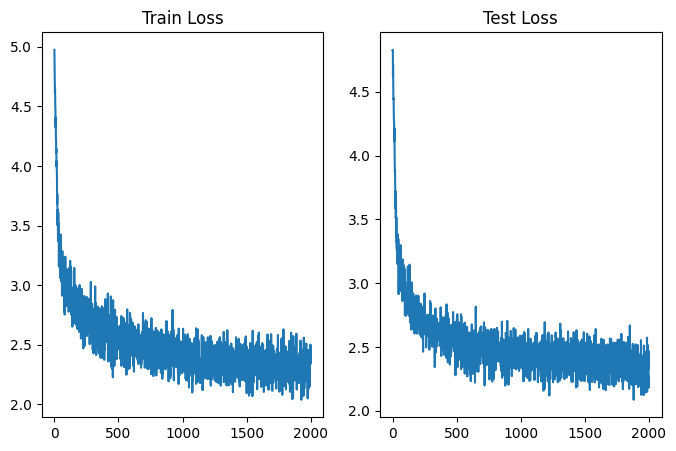

In [110]:
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.title("Train Loss")
plt.plot(train_lossi)
plt.subplot(1, 2, 2)
plt.title("Test Loss")
plt.plot(test_lossi);

</br></br>

### Generate New Text
---

In [111]:
x = torch.ones((1, 1), dtype=torch.long).to(DEVICE)

In [114]:
max_new = 1000

for _ in range(max_new):
  output = transformer(x[:, -CONTEXT_LENGTH:])
  logits = output[:, -1, :]
  probs = F.softmax(logits, dim=-1)
  x_next = torch.multinomial(probs, num_samples=1)
  x = torch.cat((x, x_next), dim=1)

In [115]:
print(''.join(decode(x[0].detach().numpy())))

Sainceveremm ofov and wartionn he sassie, per the of
saldtionglly as, rof to sowspemm-sarsysaging var As
the intes!. 3; Mod thev gludl
pinced
rewacten] diterllued ot ofrmasmand fridjuwenblelle por, ass
Ey ap ofsgese supeald thok. T6CPuat. Hoagaris dis theirly lamper, arvev perechicure chadmelas. Afwilf lifnald soued grooftavilechod dimars it thas the bud llrot movses smoind hears cray, in echund carm." The the cos."
 Nhey is the Sourly with her blulged cand conowse of exintes, wShes, of be gollinteeg Canciry ars thes werely the, merondadem of Saly
hesal at!" Le" sunpiner RuqFre usI8'; ra dyebvesish sor, Pidmper
and thed sreand the here wsinners nowcland mengromer. ef yor wheans as in rog ald
ish tmardac tNaly blleand, vent oos tand, schesed-ras on bane my at to the infonire the of cong, of Levy."
"Wooninker.
"O.='--6NA, richkys lous, and vichorkoing
pilly
to rtomes. Acdsy ome surmiving onet dond and the facluet or illes muther you, tarkily has-beankacty eculve cay ryidenred Prlas, nowt

</br></br>

Credits: 
- https://www.youtube.com/watch?v=kCc8FmEb1nY